# <center>**Projeto de Disciplina de Validação de modelos de clusterização [24E4_3]**</center>
# <center>**Aluna: Rachel Reuters**</center>

## PARTE 1- INFRAESTRUTURA

In [21]:
import platform
import sys

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Architecture:", platform.architecture())
print("Processor:", platform.processor())
print("System:", platform.system())
print("Machine:", platform.machine())
print("Release:", platform.release())
print("Node:", platform.node())

Python version: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.22621-SP0
Architecture: ('64bit', 'WindowsPE')
Processor: Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
System: Windows
Machine: AMD64
Release: 10
Node: DESKTOP-4U6C9N4


In [22]:
import subprocess

def get_conda_info():
    result = subprocess.run(['conda', 'info'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

print("Conda Info:")
get_conda_info()


Conda Info:

     active environment : py39
    active env location : C:\Users\belch\anaconda3\envs\py39
            shell level : 1
       user config file : C:\Users\belch\.condarc
 populated config files : C:\Users\belch\.condarc
          conda version : 24.5.0
    conda-build version : 24.5.1
         python version : 3.12.4.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=skylake
                          __conda=24.5.0=0
                          __cuda=12.6=0
                          __win=0=0
       base environment : C:\Users\belch\anaconda3  (writable)
      conda av data dir : C:\Users\belch\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                        

In [23]:

with open('requirements.txt', 'r') as file:
    requirements = file.read()

print(requirements)

matplotlib==3.9.2
numpy==1.26.4
pandas==2.2.1
scikit-learn==1.5.2
scipy==1.13.1
seaborn==0.13.2
scikit-learn-extra==0.3.0
data_science_utils==1.8.0


## PARTE 2 - ESCOLHA DA BASE DE DADOS

In [ ]:
#1. Escolha uma base de dados para realizar o trabalho. Essa base será usada em um problema de clusterização.
# Escolhi utilizar o dataset do Spotify https://www.kaggle.com/datasets/sanjanchaudhari/spotify-dataset?select=cleaned_dataset.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt 
import seaborn as sns

dataset_original = pd.read_csv('cleaned_dataset.csv', sep=',', decimal='.')

print("Numero de Musicas do dataset: ", dataset_original.shape[0])


#2. Escreva a justificativa para a escolha de dados, dando sua motivação e objetivos.
# Gostaria de fazer um sistema de recomendacao de musicas. Onde eu possa colocar uma musica de exemplo 
# e gostaria que o programa me falasse quais musicas sao parecidas.

#3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. 
# Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

#Irei remover algumas colunas que nao sao relevantes para a analise sendo feita
dataset_original.drop(['Licensed','official_video','Stream', 'most_playedon', 'Channel', 'Album_type' ] , axis=1, inplace=True)

print("Tipos de dados:")
print(dataset_original.dtypes)


#Para a analise vamos utilizar apenas os dados numericos :

dataset_numerico = dataset_original.drop(['Artist', 'Track', 'Album', 'Title' ], axis=1)


print("Quantidade de colunas para analise:")
print(dataset_numerico.shape[1])


#Verificar se tem nulos
print("Dados faltantes:")
print(dataset_numerico.isna().sum())

#Como sao apenas 2 linhas e nao acredito que colocar um valor sem saber a origem correta seria a melhor opcao, irei remover esses dois itens
dataset_numerico = dataset_numerico.dropna(subset=['EnergyLiveness'], axis=0 )
                       


print("Novo Numero de Musicas do dataset: ", dataset_numerico.shape[0])

plt.figure(figsize=(40, 14))

for index, value in enumerate(dataset_numerico.columns):
    plt.subplot(3, 5,index+1)
    sns.histplot(dataset_numerico[value], kde=True)





Numero de Musicas do dataset:  20594
Tipos de dados:
Artist               object
Track                object
Album                object
Danceability        float64
Energy              float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Instrumentalness    float64
Liveness            float64
Valence             float64
Tempo               float64
Duration_min        float64
Title                object
Views               float64
Likes               float64
Comments            float64
EnergyLiveness      float64
dtype: object
Quantidade de colunas para analise:
14
Dados faltantes:
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_min        0
Views               0
Likes               0
Comments            0
EnergyLiveness      2
dtype: int64
Novo Numero de Musicas do dataset:  20592


In [150]:
#4. Realize o pré-processamento adequado dos dados. Descreva os passos necessários.

# Podemos observar que a coluna de comentario pode nao refletir muita informacao para diferenciar as musicas, podendo ser
# comentario positivo ou negativo. Alem disso o numero de views e likes tambem sao parametros subjetivos. 

dataset_numerico = dataset_numerico.drop(['Comments', 'Views', 'Likes'], axis=1)


In [142]:
dataset_numerico.columns

Index(['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_min',
       'EnergyLiveness'],
      dtype='object')

In [205]:

#Alem disso podemos verificar que os dados estao com escalas diferentes. Precisamos aplicar uma normalizacao. 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats 

def calcular_indice_medio_correlacao(data):
    correlation_matrix = data.corr()
    correlation_values = correlation_matrix.values
    correlation_values_no_diag = correlation_values[np.triu_indices_from(correlation_values, k=1)]
    return np.mean(correlation_values_no_diag)



transformacoes = ['Log', 'Sqrt', 'QuantileTransformer', 'MinMax', 'Standard']
resultados = []

# Loop sobre cada transformação
for trans in transformacoes:
    if trans == 'Log':
        data_trans = np.log1p(dataset_numerico)
    elif trans == 'Sqrt':
        data_trans = np.sqrt(dataset_numerico)
    elif trans == 'QuantileTransformer':
        pt = QuantileTransformer(output_distribution='uniform')
        data_trans = pd.DataFrame(pt.fit_transform(dataset_numerico), columns=dataset_numerico.columns)
    elif trans == 'MinMax':
        scaler = MinMaxScaler()
        data_trans = pd.DataFrame(scaler.fit_transform(dataset_numerico), columns=dataset_numerico.columns)
    elif trans == 'Standard':
        scaler = StandardScaler()
        data_trans = pd.DataFrame(scaler.fit_transform(dataset_numerico), columns=dataset_numerico.columns)
    
    indice_medio_correlacao = calcular_indice_medio_correlacao(data_trans)
    resultados.append({"Metodo Transformacao": trans, "Correlacao Media": indice_medio_correlacao })


resultados_comparados = pd.DataFrame(resultados)

print(resultados_comparados)

scaler = MinMaxScaler()
data_trans = pd.DataFrame(scaler.fit_transform(dataset_numerico), columns=dataset_numerico.columns)
dataset_normalizado = data_trans
# plt.figure(figsize=(40, 14))

# for index, value in enumerate(dataset_normalizado.columns):
#     plt.subplot(3, 5,index+1)
#     sns.histplot(dataset_normalizado[value], kde=True)
#     plt.xlabel(dataset_numerico.columns[index])


  Metodo Transformacao  Correlacao Media
0                  Log         -0.005788
1                 Sqrt         -0.014452
2  QuantileTransformer          0.012887
3               MinMax          0.004605
4             Standard          0.004605


c:\Users\belch\anaconda3\envs\py39\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
c:\Users\belch\anaconda3\envs\py39\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


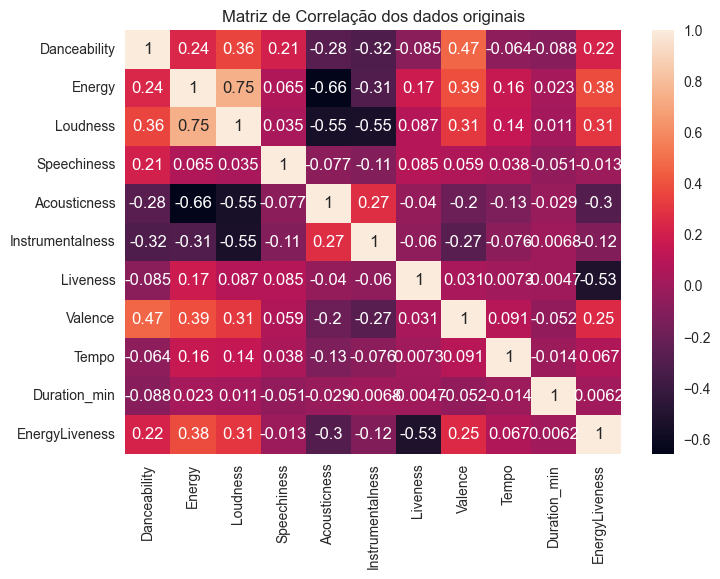

In [197]:

correlation_matrix = dataset_numerico.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matriz de Correlação dos dados originais')
plt.show()

In [ ]:
#Podemos observar que na matriz de correlacao, existem muitas correlacoes negativas, com valores bem baixos e proximos de 0.
#Sugere que as propriedades sao independentes ou a relacao nao 'e linear. 

## PARTE 3 - CLUSTERIZAÇÃO

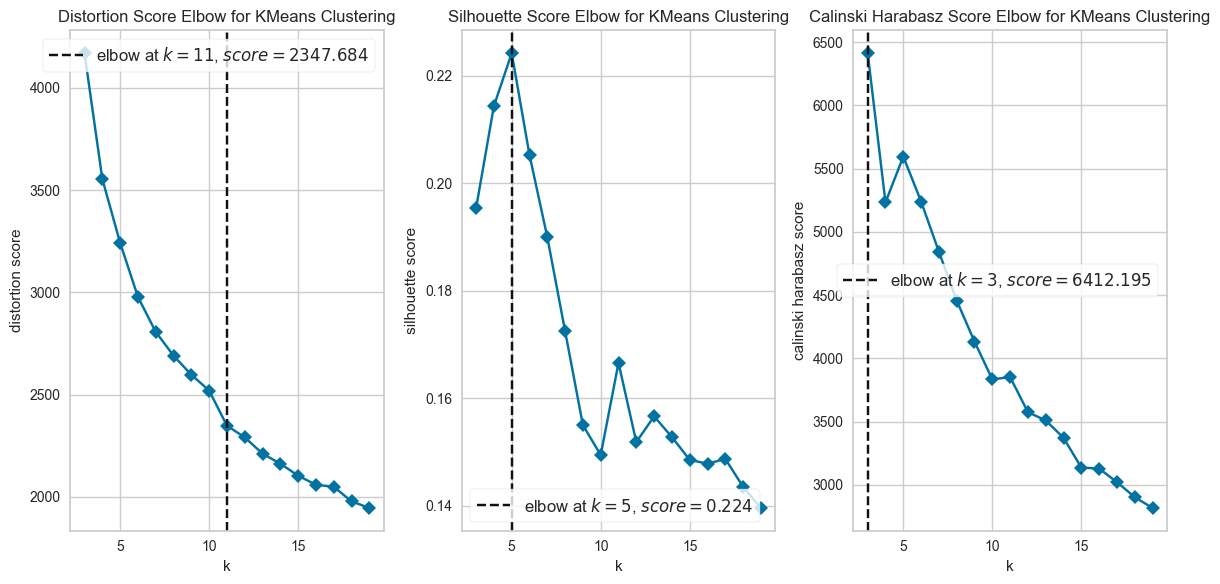

In [206]:
#1. Realizar o agrupamento dos dados, escolhendo o número ótimo de clusters. 
# Para tal, use o índice de silhueta e as técnicas:
#K-Médias
#DBScan

# Atualmente, a lib  Yellowbrick fornece dois visualizadores para avaliar mecanismos centróides, particularmente 
# o K-Means, e ajuda  a descobrir um K ideal na métrica de clustering:

# O KElbowVisualizer visualiza os clusters de acordo com uma função de pontuação, procurando por um "cotovelo" na curva.
# SilhouetteVisualizer visualiza as pontuações de silhueta de cada cluster em um único modelo.

# Por padrão, a métrica do parâmetro de pontuação é definida como distorção, que calcula a soma das distâncias quadradas 
# de cada ponto até seu centro atribuído. No entanto, duas outras métricas também podem ser usadas com o KElbowVisualizer:
# silhueta e calinski_harabaz. A pontuação da silhueta é o coeficiente médio da silhueta para todas as amostras,
# enquanto a pontuação calinski_harabaz calcula a proporção de dispersão entre e dentro dos clusters.


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

visualizer = KElbowVisualizer(model,ax=axes[0], k=(3,20), timings=False)

visualizer.fit(dataset_normalizado)   
visualizer.finalize()  

visualizer2 = KElbowVisualizer(model,ax=axes[1], k=(3,20), metric='silhouette', timings=False)

visualizer2.fit(dataset_normalizado)   
visualizer2.finalize()  


visualizer3 = KElbowVisualizer(model,ax=axes[2], k=(3,20), metric='calinski_harabasz', timings=False)

visualizer3.fit(dataset_normalizado)   
visualizer3.finalize()  


plt.tight_layout()
plt.show()

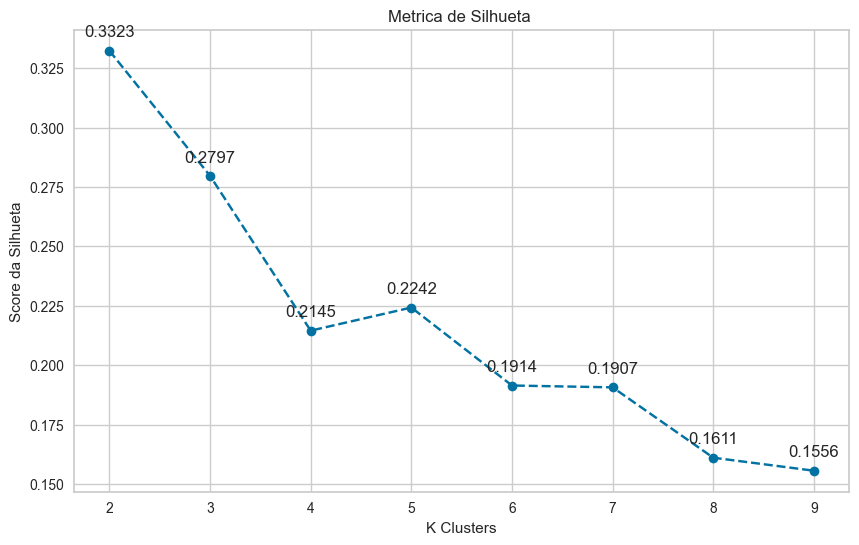

In [207]:
from sklearn.metrics import silhouette_score
# Define a range of cluster numbers to evaluate
range_n_clusters = range(2, 10)

# List to store silhouette scores
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=22)
    cluster_labels = kmeans.fit_predict(dataset_normalizado)
    silhouette_avg = silhouette_score(dataset_normalizado, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--', color='b')

for i, txt in enumerate(silhouette_scores): 
    plt.annotate(f'{txt:.4f}', (range_n_clusters[i], silhouette_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Metrica de Silhueta ')
plt.xlabel('K Clusters')
plt.ylabel('Score da Silhueta')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


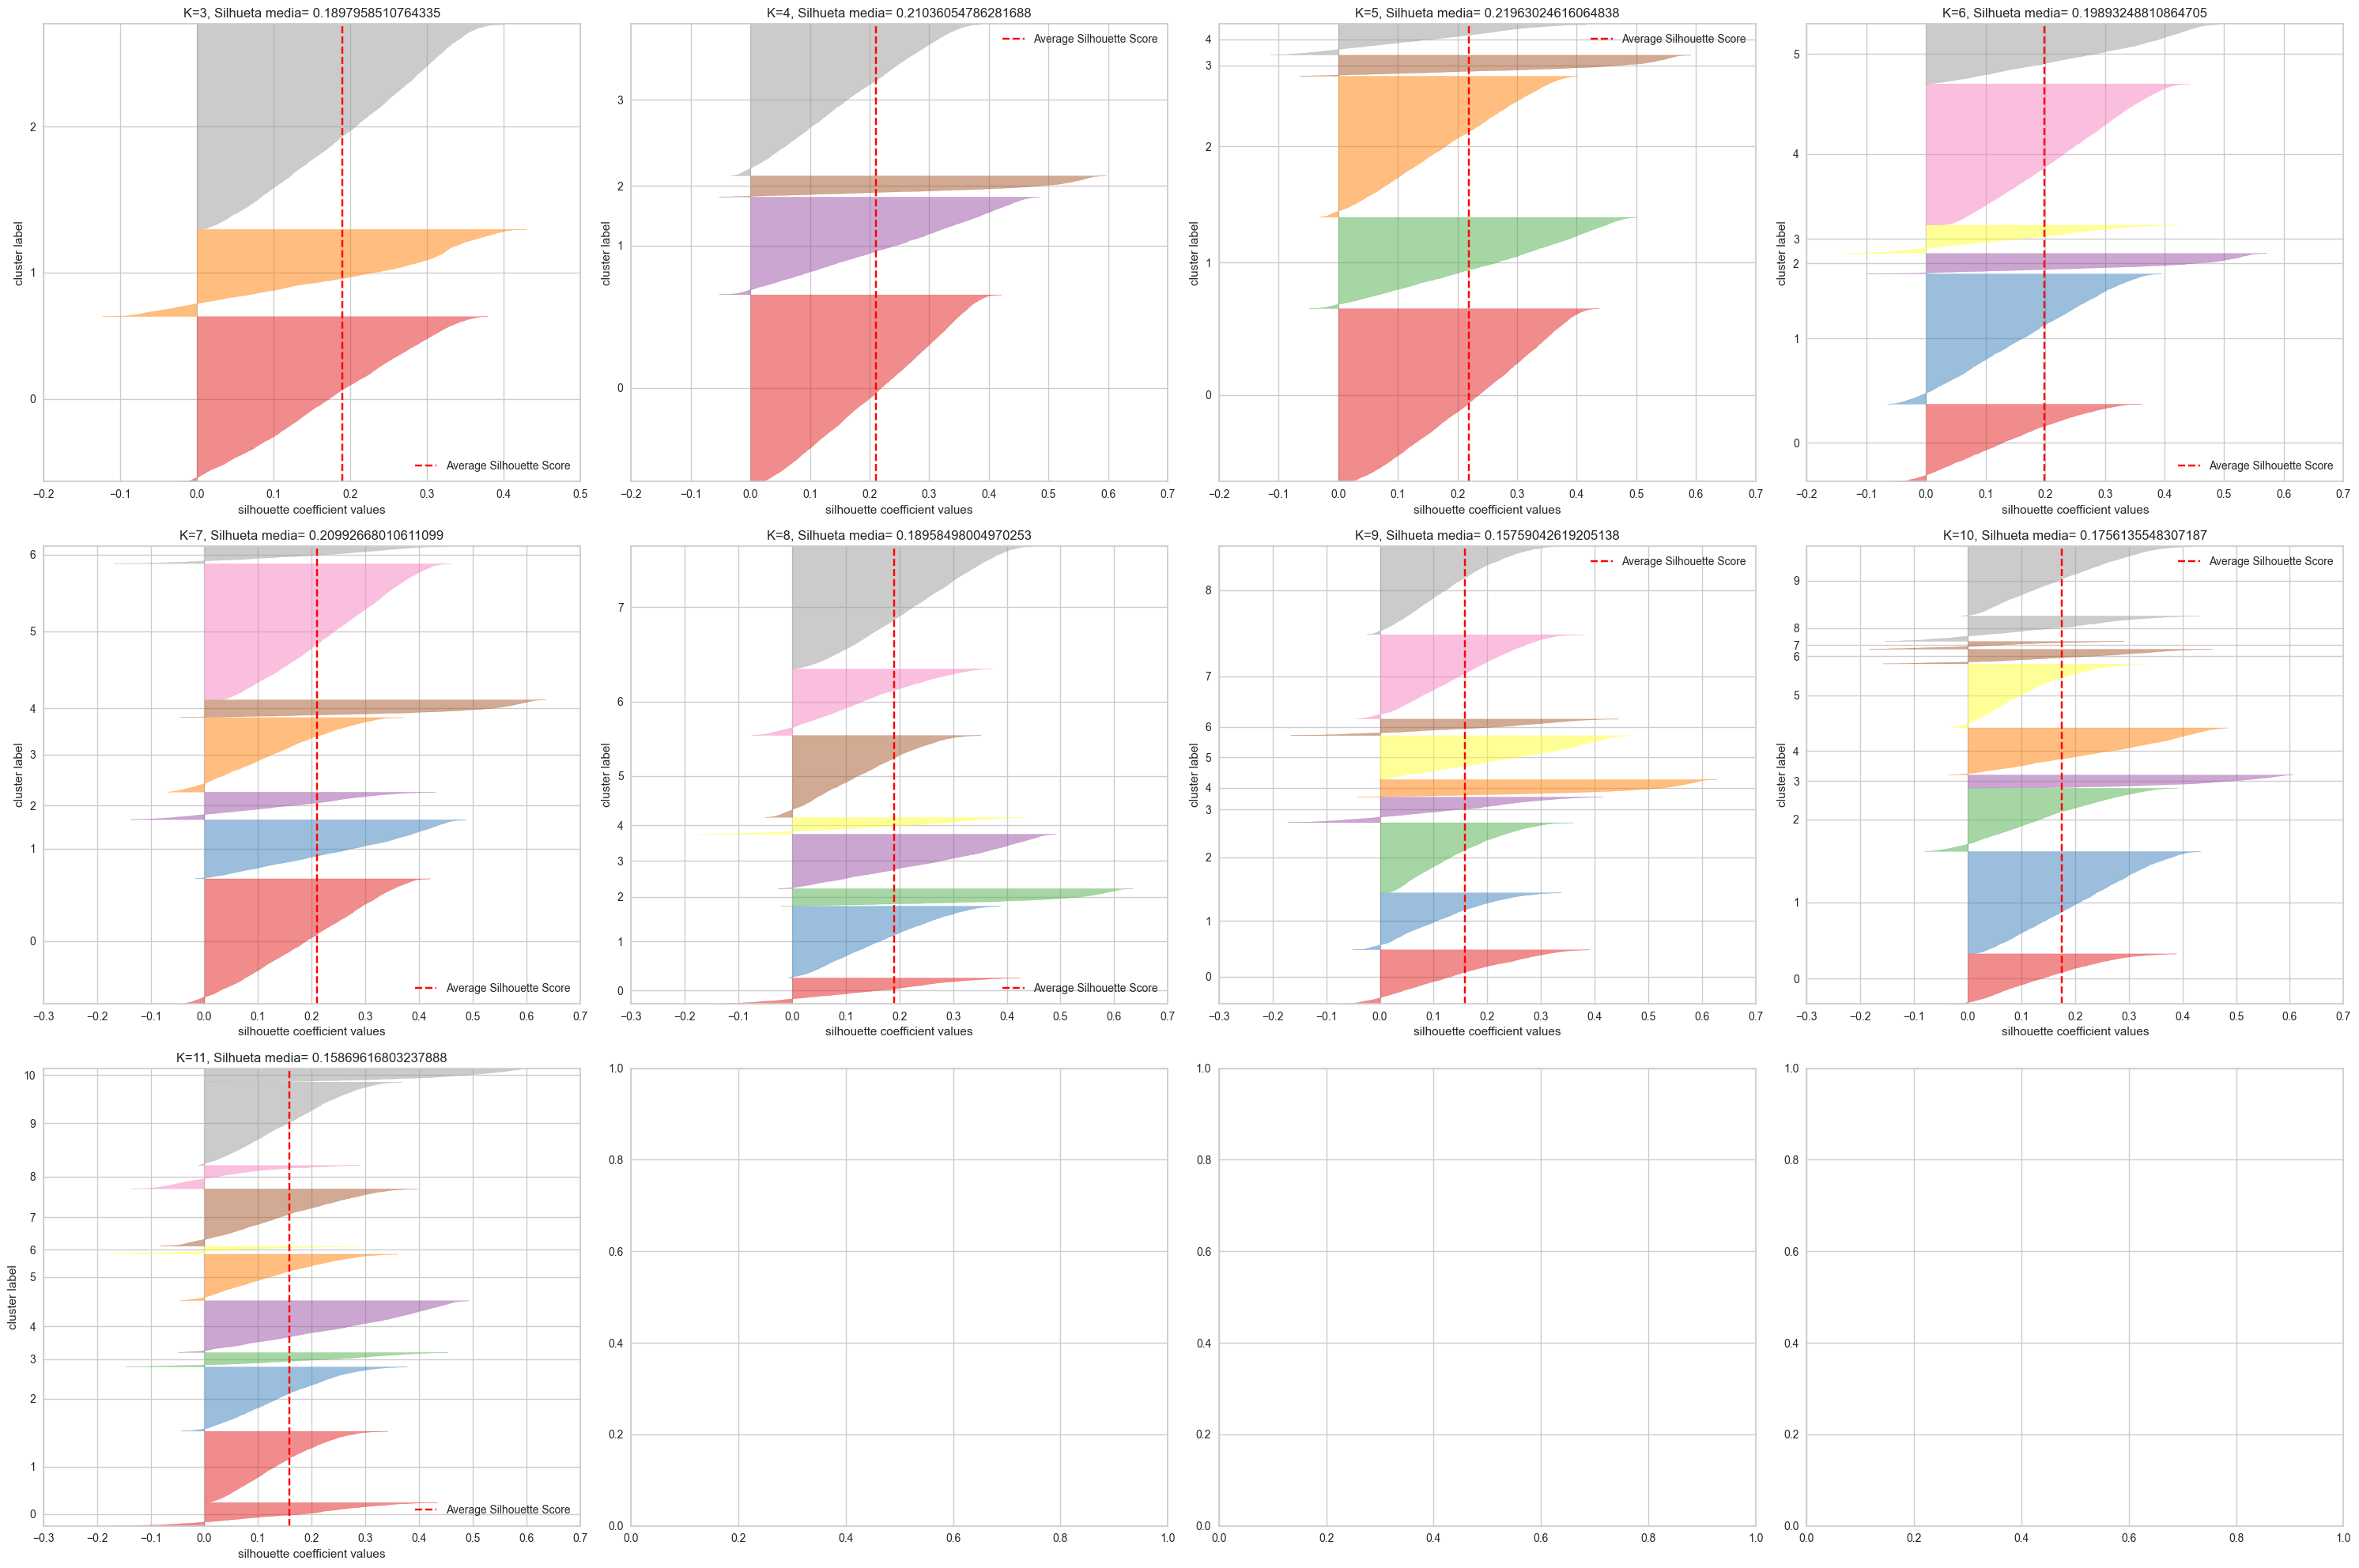

In [168]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import metrics

model = KMeans()
fig, axes = plt.subplots(3, 4, figsize=(30, 20))
axes = axes.flatten()
for i, k in enumerate(range(3, 12)):
    model = KMeans(k)
    visualizer = SilhouetteVisualizer(model,ax=axes[i])
    visualizer.fit(dataset_normalizado)   
    visualizer.finalize()  
    silhouette_samples = metrics.silhouette_samples(dataset_normalizado, model.labels_)
    axes[i].set_title(f"K={k}, Silhueta media= {silhouette_samples.mean()}")




plt.tight_layout()
plt.show()

In [ ]:
#2 Com os resultados em mão, descreva o processo de mensuração do índice de silhueta. 
# Mostre o gráfico e justifique o número de clusters escolhidos.

#Fazendo um panorama entre todos as metricas utilizafas, o melhor 'e agrupar em 5 clusteres. 
# Porem podemos observar no plot  de silhueta que os dados nao estao muito bem classificados, tem muito registro em  3 grupos
# e poucas musicas em 2 grupos. Tanto 'e que o indice de silhueta deu apenas 0.22

In [ ]:
#Apenas para fazer um teste, escolhi uma musica e quero entender quais 5 musicas sao parecidas com essa e sao recomendadas para mim 

linha_dataset_musica = dataset_original[dataset_original['Track'] == "What I've Done"]
indice_musica_escolhida = dataset_original.index[dataset_original['Track'] == "What I've Done"].to_list()[0]
print("Indice da musica")
print(indice_musica_escolhida)


kmeans = KMeans(n_clusters=5, random_state=22)
model = kmeans.fit(dataset_normalizado)

distancias = kmeans.transform(dataset_normalizado)

cluster_labels = kmeans.predict(dataset_normalizado)


dataset_normalizado_com_cluster = dataset_normalizado.copy()
dataset_normalizado_com_cluster['cluster'] = cluster_labels

cluster_da_minha_musica = cluster_labels[indice_musica_escolhida]

dataset_do_cluster_da_minha_musica = dataset_normalizado[dataset_normalizado_com_cluster['cluster'] ==cluster_da_minha_musica]

distancias = pd.DataFrame(distancias)


distancias["Track"] = dataset_original['Track']
distancias["Artist"] = dataset_original['Artist']

distancias["cluster"] = cluster_labels
distancias = distancias.sort_values(by=['cluster', cluster_da_minha_musica])

mais_proximos_centro = distancias.head()

Musicas_Selecionadas = mais_proximos_centro[['Track', 'Artist']].values.tolist()
print("Musicas mais parecidas de acordo com a clusterizacao ")
print(Musicas_Selecionadas)



Indice da musica
62
Musicas mais parecidas de acordo com a clusterizacao 
[["2012 (It Ain't The End)", 'Jay Sean'], ['You Oughta Know - 2015 Remaster', 'Alanis Morissette'], ['Ayúdame a Imaginar', 'Pablo Chill-E'], ['Lo Que Había Olvidado', 'Andrés Cepeda'], ['Si la Ves (feat. Sin Bandera)', 'Franco De Vita']]


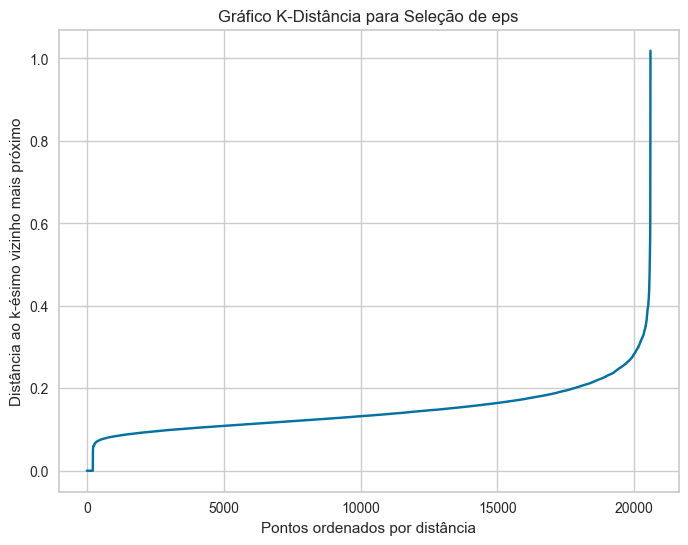

In [ ]:
#Para a analise do DBscan , vou realizar uma iteracao com alguns valores possiveis de eps e tambem de min_samples.

# Para os possiveis valores de eps, vou realizar uma analise com KNN usando o valor previamente escolhido no KMEANS = 5 
# Encontrar o cotovelo do plot

from sklearn.neighbors import NearestNeighbors

k = 5

# Calcular as distâncias k-ésimas mais próximas
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(dataset_normalizado)
distances, indices = neighbors_fit.kneighbors(dataset_normalizado)

# Ordenar as distâncias
distances = np.sort(distances[:, k-1])

# Plotar o gráfico K-Distância
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.xlabel('Pontos ordenados por distância')
plt.ylabel('Distância ao k-ésimo vizinho mais próximo')
plt.title('Gráfico K-Distância para Seleção de eps')
plt.show()

In [ ]:
#Pelo plot acima o valor possivel para eps esta proximo dos 0.3 onde acontece um  aumento subito.

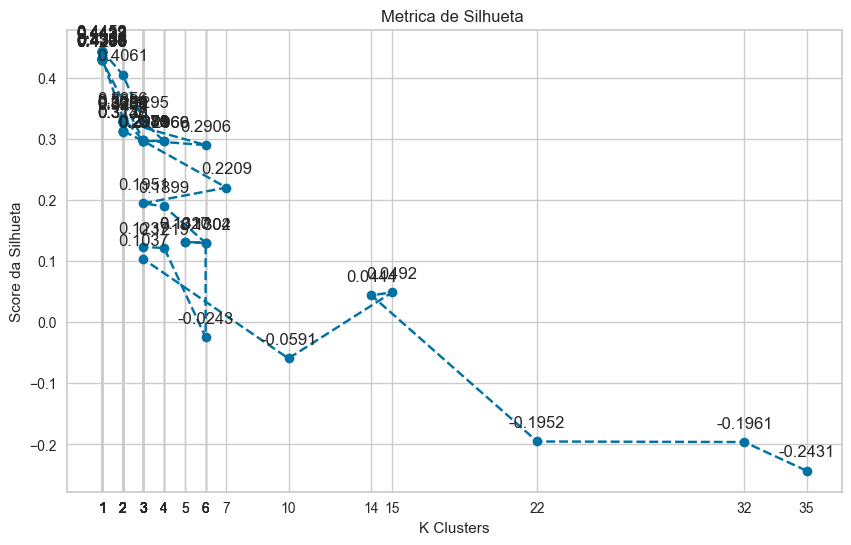

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

final_result = []
for eps in np.arange(0.2,0.6, 0.1):
    for samples in np.arange(4, 20,1 ):
        dbscan = DBSCAN(eps, min_samples=samples)
        labels = dbscan.fit_predict(dataset_normalizado)
        
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(dataset_normalizado, labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            final_result.append({"n_clusters": n_clusters, "silhueta": silhouette_avg, "eps": eps, "min_samples": samples})
        else:
            final_result.append({"n_clusters": 0, "silhueta": -1, "eps": eps, "min_samples": samples})


final_result_df = pd.DataFrame(final_result)

plt.figure(figsize=(10, 6))
plt.plot(final_result_df['n_clusters'], final_result_df['silhueta'] , marker='o', linestyle='--', color='b')

for i, row in final_result_df.iterrows(): 
    plt.annotate(f'{row["silhueta"]:.4f}', (row['n_clusters'], row['silhueta']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title('Metrica de Silhueta ')
plt.xlabel('K Clusters')
plt.ylabel('Score da Silhueta')
plt.xticks(final_result_df['n_clusters'])
plt.grid(True)
plt.show()

In [214]:
final_result_df = final_result_df.sort_values(by=['silhueta'], ascending= False)

#Nao faz muito sentido dividir tantas musicas em tao poucos grupos. acredito que o minimo para esse padrao de dados seja 5. 
filtered_data = final_result_df.loc[final_result_df['n_clusters'] > 4]
                         

filtered_data.head(20)

,n_clusters,silhueta,eps,min_samples
32,6,0.290588,0.4,4
16,7,0.220930,0.3,4
12,5,0.131982,0.2,16
11,5,0.131713,0.2,15
13,6,0.130384,0.2,17
10,6,0.130214,0.2,14
4,15,0.049177,0.2,8
3,14,0.044380,0.2,7
9,6,-0.024350,0.2,13
5,10,-0.059114,0.2,9


Silhouette Score médio: 0.290587680811708


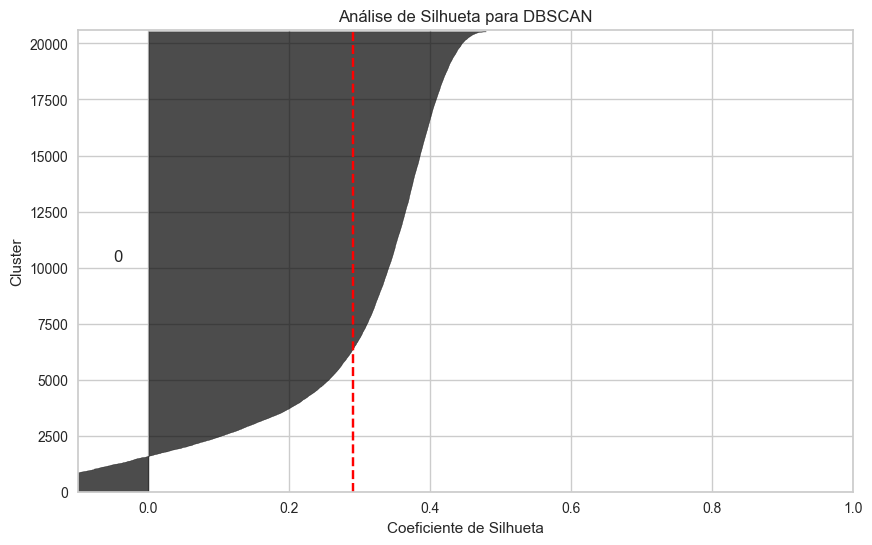

In [215]:
from sklearn.metrics import silhouette_samples, silhouette_score
#Um resultado que aparentemente tem  uma boa metrica 'e' o de 6 clusters
# Valor de eps: 0.4 e min_samples: 4

# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=4).fit(dataset_normalizado)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

silhouette_avg = silhouette_score(dataset_normalizado, labels)
sample_silhouette_values = silhouette_samples(dataset_normalizado, labels)

print(f"Silhouette Score médio: {silhouette_avg}")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Set the range for the silhouette plot
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(dataset_normalizado) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title("Análise de Silhueta para DBSCAN")
ax1.set_xlabel("Coeficiente de Silhueta")
ax1.set_ylabel("Cluster")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.show()


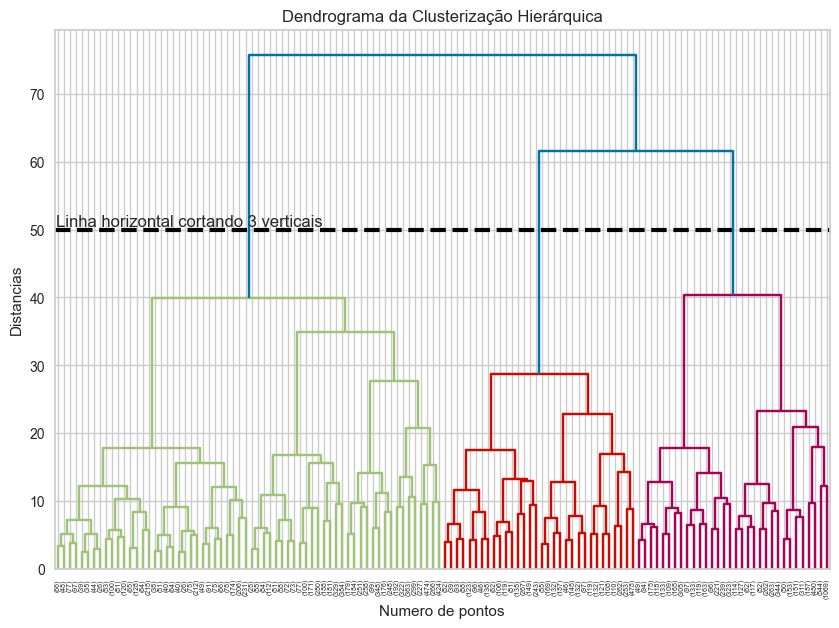

In [194]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    return dendrogram(linkage_matrix, **kwargs)

#Parte 3.3  Para os resultados da Clusterização Hierárquica, apresente o dendograma
cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = cluster.fit(dataset_normalizado)

plt.figure(figsize=(10, 7))
plt.title('Dendrograma da Clusterização Hierárquica')
plt.ylabel('Distancias')
plt.hlines(y=50,xmin=0,xmax=2000,lw=3,linestyles='--',colors='black' )
plt.text(x=2,y=50.5,s='Linha horizontal cortando 3 verticais',fontsize=12)
#plt.grid(True)
dendro=plot_dendrogram(model, truncate_mode='level', p=6)
plt.xlabel("Numero de pontos")
plt.show()